# S&P 500

## Import Libraries

In [15]:
import pandas as pd
import os
from os import listdir
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association
import scipy.stats as stats

import numpy as np

from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde

import warnings
warnings.filterwarnings("ignore")

## Import Data

In [ ]:
df = pd.read_csv("archive/sp500_stocks.csv")
sp = df["Symbol"].unique()
sp.sort()
sp = list(sp)

In [3]:
data = os.listdir("data")
data.sort()
data = list(data)

In [53]:
# create master dataframe from single dfs
"""
df = pd.DataFrame()
for i in data:
    if i.replace(".csv", "") in sp:
        df2 = pd.read_csv(f"data/{i}")
        df2["company"] = i.replace(".csv", "")
        df = pd.concat([df, df2], ignore_index=True)
"""

'\ndf = pd.DataFrame()\nfor i in data:\n    if i.replace(".csv", "") in sp:\n        df2 = pd.read_csv(f"data/{i}")\n        df2["company"] = i.replace(".csv", "")\n        df = pd.concat([df, df2], ignore_index=True)\n'

In [5]:
#df.to_csv("master1.csv")

In [22]:
df = pd.read_csv("master1.csv")

## Cleaning

In [23]:
# cleaning

df.columns = [columns.lower().replace(" ", "_") for columns in df.columns]
df["date"] = pd.to_datetime(df["date"])
df.set_index("date", inplace=True) # set date as index
df.drop(columns="unnamed:_0", inplace=True) # drop unnamed column

## Basic Exploration

In [8]:
df.shape

(4232675, 8)

In [9]:
# number of companies
len(df["company"].unique())

500

In [10]:
df.head(3)

,open,high,low,close,volume,dividends,stock_splits,company
date,,,,,,,,
1999-11-18 00:00:00-05:00,27.466220,30.182662,24.146128,26.560741,62546380,0.0,0.0,A
1999-11-19 00:00:00-05:00,25.919355,25.957085,24.032940,24.372496,15234146,0.0,0.0,A
1999-11-22 00:00:00-05:00,24.938423,26.560741,24.183856,26.560741,6577870,0.0,0.0,A


Text(0, 0.5, 'Price')

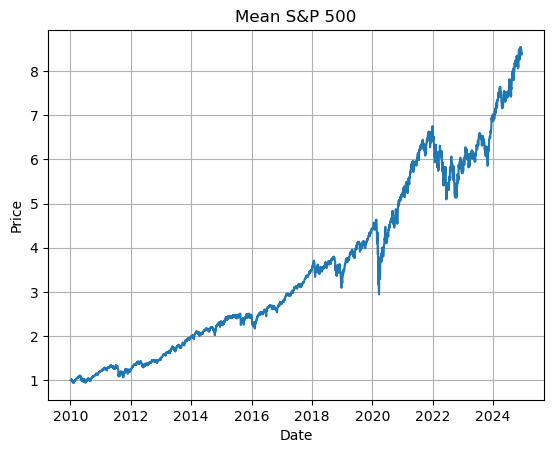

In [13]:
# plotting mean S&P 500 value since 2010

mean = df.groupby("date")["close"].mean().reset_index()

mean_2010 = mean.copy()
mean_2010["date"] = pd.to_datetime(mean_2010["date"], utc=True)
mean_2010 = mean_2010.set_index("date")
mean_2010 = mean_2010.loc["2010":]

start = mean_2010.iloc[0] # starting value for normalizing
mean_2010 = mean_2010/start # normalizing values

sns.lineplot(data=mean_2010, x="date", y="close")

plt.grid(True)
plt.title('Mean S&P 500')
plt.xlabel('Date')
plt.ylabel('Price')

## Feature Engineering

In [24]:
# normalize price, starting 2010
df_2010 = df.copy().sort_index()
df_2010 = df_2010.reset_index()
df_2010["date"] = pd.to_datetime(df_2010["date"], utc=True)
df_2010 = df_2010.set_index("date")
df_2010 = df_2010.loc["2010":]

df_2010["norm_price_2010"] = df_2010.groupby("company")["close"].transform(lambda x: x / x.iloc[0])

In [25]:
# add sector information from webscraping
sector_df = pd.read_csv('/Users/jangfeller/Library/Mobile Documents/com~apple~CloudDocs/_Ironhack/projects/mid_project/app/utils/sector_df.csv')
df_2010 = df_2010.reset_index()
df_2010_sector = df_2010.merge(sector_df, on="company", how="left")
df_2010_sector = df_2010_sector.drop(columns="Unnamed: 0")

In [26]:
# strip time
df_2010_sector["date"] = pd.to_datetime(df_2010_sector["date"]).dt.date

In [27]:
# add marketcap data from webscraping
caps_df = pd.read_csv('/Users/jangfeller/Library/Mobile Documents/com~apple~CloudDocs/_Ironhack/projects/mid_project/app/utils/caps_df.csv')
df_2010_sector_caps = df_2010_sector.merge(caps_df, on="company", how="left")
df_2010_sector_caps = df_2010_sector_caps.drop(columns="Unnamed: 0")

In [28]:
df_2010_sector_caps["marketcap"] = df_2010_sector_caps["marketcap"].map(lambda x: x.replace("B", "").replace(",", ""))
df_2010_sector_caps["marketcap"] = df_2010_sector_caps["marketcap"].map(lambda x: pd.to_numeric(x))

In [12]:
df_2010_sector_caps["subsector"].nunique()

126

In [49]:
df.head(3)

,open,high,low,close,volume,dividends,stock_splits,company
date,,,,,,,,
1999-11-18 00:00:00-05:00,27.466220,30.182662,24.146128,26.560741,62546380,0.0,0.0,A
1999-11-19 00:00:00-05:00,25.919355,25.957085,24.032940,24.372496,15234146,0.0,0.0,A
1999-11-22 00:00:00-05:00,24.938423,26.560741,24.183856,26.560741,6577870,0.0,0.0,A


In [52]:
df_2010_sector_caps.head(10)

,date,open,high,low,close,volume,dividends,stock_splits,company,norm_price_2010,sector,subsector,marketcap
0,2010-01-04,26.657596,26.781511,26.192907,26.285845,4152133,0.0,0.0,DUK,1.0,utilities,Electric Utilities,88.22
1,2010-01-04,15.435000,15.770000,15.295000,15.455000,1663200,0.0,0.0,LULU,1.0,consumer discretionary,"Apparel, Accessories & Luxury Goods",42.29
2,2010-01-04,3.178500,3.246460,3.141735,3.242003,1199700,0.0,0.0,KDP,1.0,consumer staples,Soft Drinks & Non-alcoholic Beverages,44.54
3,2010-01-04,4.238000,4.273000,4.187000,4.225000,710000,0.0,0.0,CSGP,1.0,real estate,Real Estate Services,31.30
4,2010-01-04,39.425556,39.554588,39.115881,39.432007,9190800,0.0,0.0,PG,1.0,consumer staples,Personal Care Products,414.39
5,2010-01-04,45.680105,45.680105,45.128484,45.176037,7182800,0.0,0.0,TMO,1.0,health care,Life Sciences Tools & Services,198.62
6,2010-01-04,9.628289,9.746751,9.529571,9.713844,1832400,0.0,0.0,WY,1.0,real estate,Timber REITs,22.44
7,2010-01-04,74.047682,75.058091,73.861409,74.764565,6438444,0.0,0.0,IBM,1.0,information technology,IT Consulting & Other Services,217.60
8,2010-01-04,21.616852,21.661475,21.489356,21.591352,1574200,0.0,0.0,CPB,1.0,consumer staples,Packaged Foods & Meats,12.66
9,2010-01-04,15.121361,15.200215,14.991484,15.061061,1209792,0.0,0.0,PPL,1.0,utilities,Electric Utilities,25.24


In [17]:
#df_2010_sector_caps.to_csv("master2.csv")

In [18]:
#df_2010_sector.to_csv("df_2010_sector.csv")

In [19]:
#df_2010.to_csv("df_2010.csv")

## More feature engineering

In [29]:
# create df for EDA consisting of company data, volume since 2010
master2 = df_2010_sector_caps.copy()

In [30]:
# create df with top 20 companies
eda_df = master2[["company", "marketcap"]]
eda_df.drop_duplicates(inplace=True)
eda_df = eda_df.sort_values(by="marketcap", ascending=False)
eda_df = eda_df.head(20).reset_index()

In [31]:
# merge df with sector information
volume_company = master2.groupby("company")["volume"].sum().reset_index()
sectors = master2[["company", "sector", "subsector"]]
eda_df = eda_df.merge(volume_company, how="inner", on="company")
eda_df = eda_df.merge(sectors, how="inner", on="company")
eda_df.drop_duplicates(inplace=True)
eda_df = eda_df.drop(columns="index").reset_index().drop(columns="index")

In [32]:
top_20_comp = list(eda_df["company"])

In [37]:
# dataset starting 2020
master_2020 = master2.copy()
master_2020["date"] = pd.to_datetime(master_2020["date"])
master_2020 = master_2020.set_index("date")
master_2020.sort_index(inplace=True)
master_2020 = master_2020.loc["2020":]

# add average s&p value and norm price 2020
mean_2020 = master_2020.groupby(["date", "company"])["close"].mean().reset_index()
mean_2020.columns = ["date", "company", "average"]
master_2020 = master_2020.merge(mean_2020, how="inner", on=["date", "company"])
master_2020["norm_price_2020"] = master_2020.groupby("company")["close"].transform(lambda x: x / x.iloc[0])
#master_2020.drop(columns="Unnamed: 0", inplace=True)

# add relative price change daily
master_2020 = master_2020.sort_values(by=["company", "date"])
master_2020["price_change"] = master_2020.groupby("company")["close"].transform(lambda x: x - x.shift(1))
master_2020["price_change"] = master_2020["price_change"] / master_2020["close"] * 100

# adding volatility
volatility_df = master_2020.groupby("company")["price_change"].std().reset_index()
volatility_df.rename(columns={"price_change": "volatility"}, inplace=True)
master_2020 = master_2020.merge(volatility_df, on="company", how="left")
master_2020.dropna(inplace=True)

# save file with all companies
master_2020_all = master_2020.copy()
master_2020_all.to_csv("master_2020_all.csv")

# using only top 20 companies
master_2020 = master_2020[master_2020["company"].isin(top_20_comp) ]

#save the .csv file
master_2020.to_csv("master_2020.csv")

## Inferential Statistics

### ANOVA: Analysis of Variance

---
Null Hypothesis:
There is no difference in volatility over different sectors of the S&P 500

Alternative Hypothesis:
There is a difference in volatility over different sectors of the S&P 500

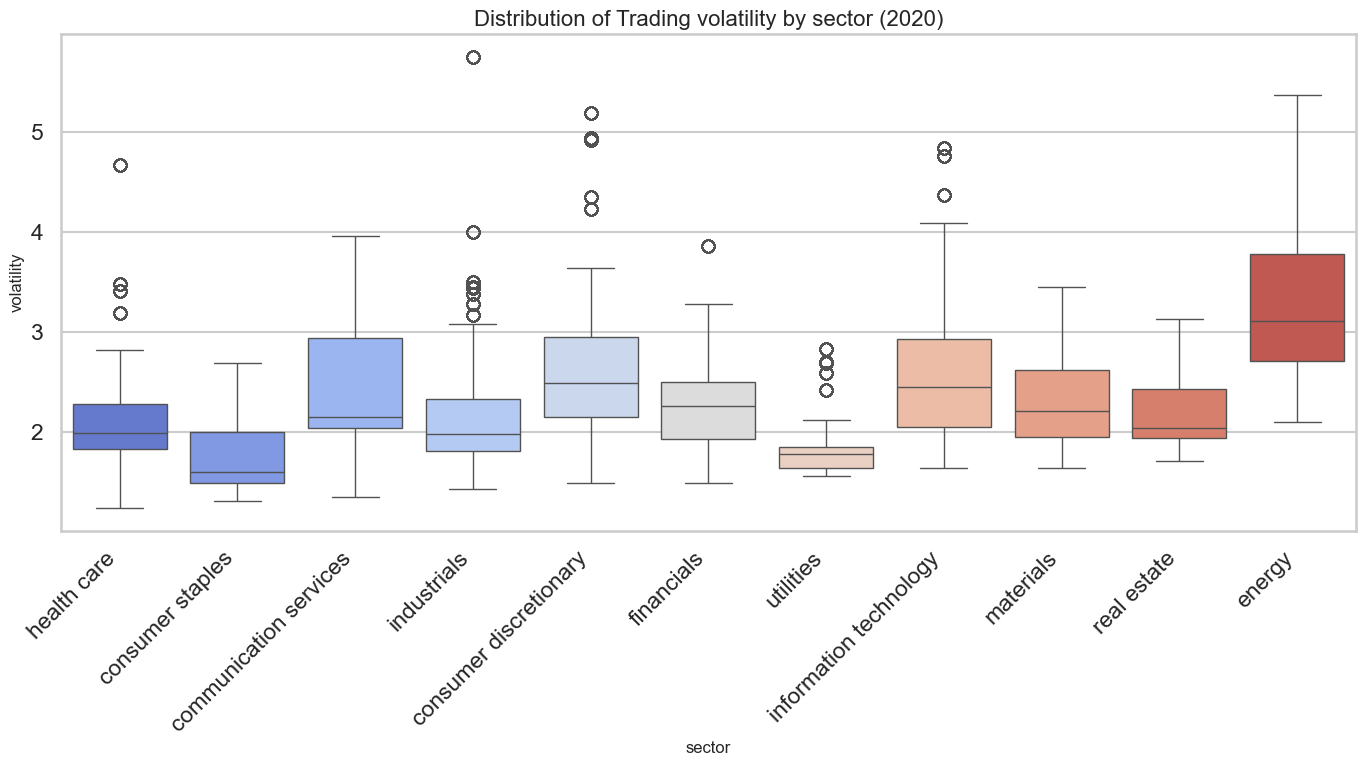

In [60]:
sorted_df = master_2020_all.sort_values(by='volatility', ascending=True)

# Set the style and context for the plot
sns.set(style="whitegrid", context="talk")

# Create the boxplot
plt.figure(figsize=(14, 8))  # Adjust the figure size for better readability
sns.boxplot(data=sorted_df, x="sector", y="volatility", palette="coolwarm")

# Improve labels and titles
plt.title('Distribution of Trading volatility by sector (2020)', fontsize=16)
plt.xlabel('sector', fontsize=12)
plt.ylabel('volatility', fontsize=12)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha="right")

# Adjust layout for better fit
plt.tight_layout()

# Show plot
plt.show()

Text(0, 0.5, 'Count')

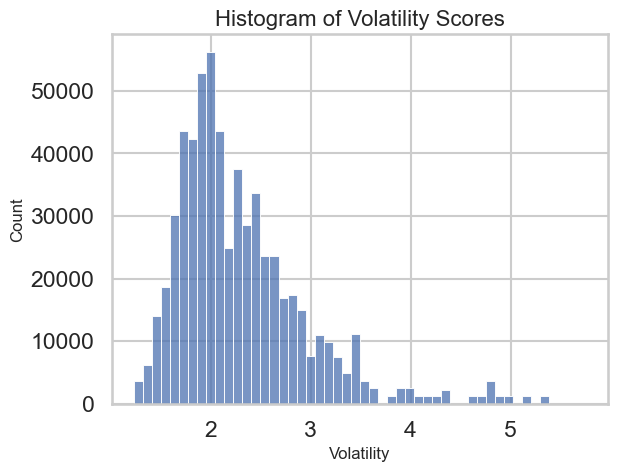

In [61]:
sns.histplot(master_2020_all["volatility"], bins=50)
plt.title("Histogram of Volatility Scores", fontsize=16)
plt.xlabel("Volatility", fontsize=12)
plt.ylabel("Count", fontsize=12)

In [43]:
inf_df = master_2020_all[["company", "sector", "volatility"]]
inf_df.drop_duplicates(inplace=True)
inf_df_group = inf_df.groupby("sector")["volatility"].agg(list).reset_index()
inf_df_group["average"] = inf_df_group["volatility"].apply(lambda x: sum(x) / len(x))
inf_df_group["std"] = inf_df_group["volatility"].apply(lambda x: np.std(x))

In [53]:
master_2020_all.groupby(by="sector")["volatility"].mean()

sector
communication services    2.337313
consumer discretionary    2.703183
consumer staples          1.774836
energy                    3.289703
financials                2.271417
health care               2.118041
industrials               2.160731
information technology    2.568747
materials                 2.330169
real estate               2.199536
utilities                 1.874696
Name: volatility, dtype: float64

In [47]:
# find p value
f_stat, p_value = stats.f_oneway(*inf_df_group["volatility"])
p_value

3.628731932809253e-22

very low p-value
--> null hypothesis is rejected. There is a clear difference in volatility over different sectors of the S&P 500.

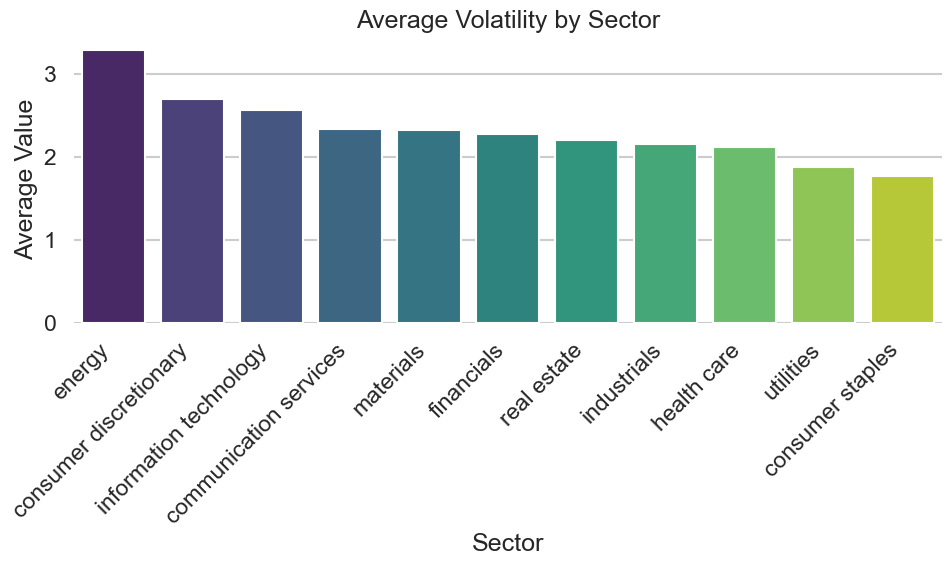

In [44]:
# plot volatility for all sectors

sorted_df = inf_df_group.sort_values(by='average', ascending=False)
plt.figure(figsize=(10, 6))

sns.barplot(x='sector', y='average', data=sorted_df, palette='viridis')
plt.xticks(rotation=45, ha='right')

plt.title('Average Volatility by Sector')
plt.xlabel('Sector')
plt.ylabel('Average Value')


sns.despine(left=True, bottom=True)  # Remove top and right spines for a cleaner look

# Show the plot
plt.tight_layout()
plt.show()

## Plots

### Boxplots

<Axes: xlabel='sector', ylabel='price_change'>

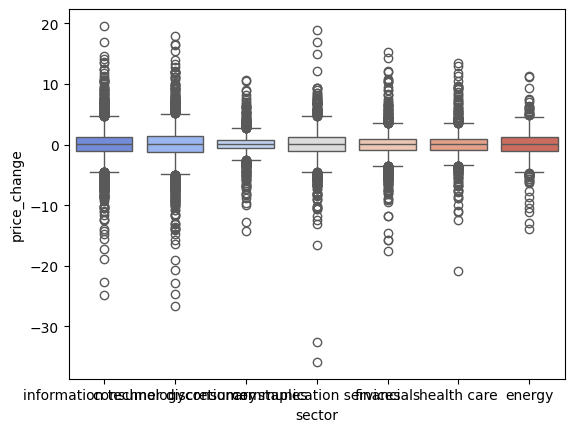

In [29]:
sns.boxplot(data=master_2020, x="sector", y="price_change", palette="coolwarm")


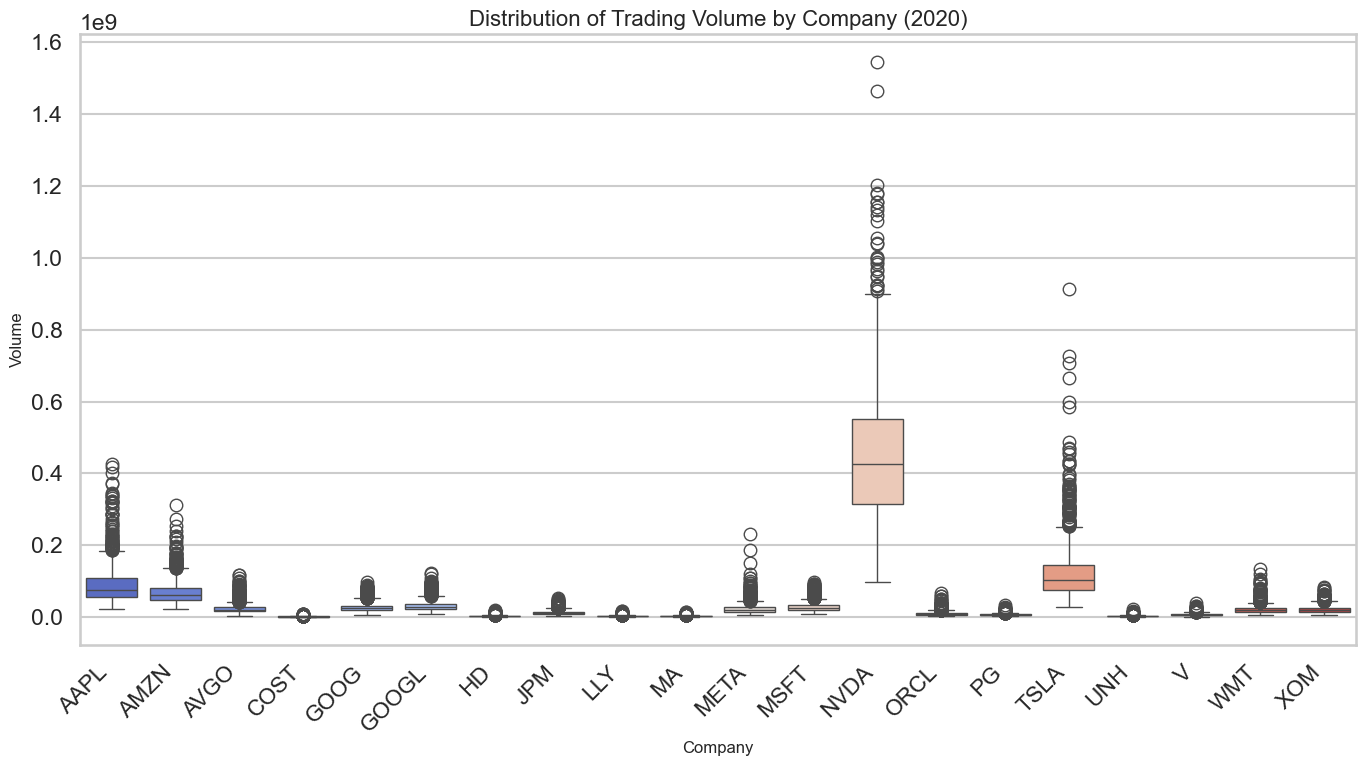

In [30]:
# Set the style and context for the plot
sns.set(style="whitegrid", context="talk")

# Create the boxplot
plt.figure(figsize=(14, 8))  # Adjust the figure size for better readability
sns.boxplot(data=master_2020, x="company", y="volume", palette="coolwarm")

# Improve labels and titles
plt.title('Distribution of Trading Volume by Company (2020)', fontsize=16)
plt.xlabel('Company', fontsize=12)
plt.ylabel('Volume', fontsize=12)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha="right")

# Adjust layout for better fit
plt.tight_layout()

# Show plot
plt.show()

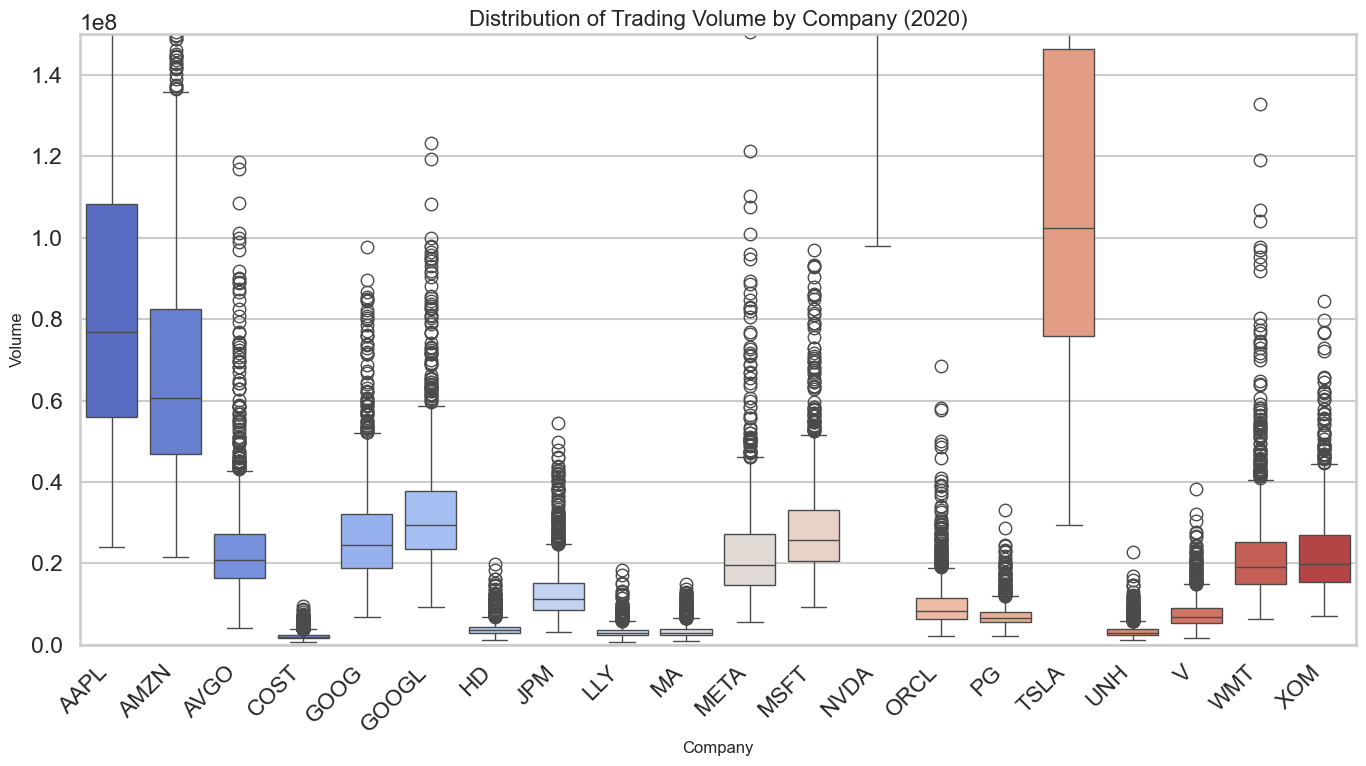

In [31]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=master_2020, x="company", y="volume", palette="coolwarm")

plt.ylim(0, 150000000)  # Set your own limits here

plt.title('Distribution of Trading Volume by Company (2020)', fontsize=16)
plt.xlabel('Company', fontsize=12)
plt.ylabel('Volume', fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

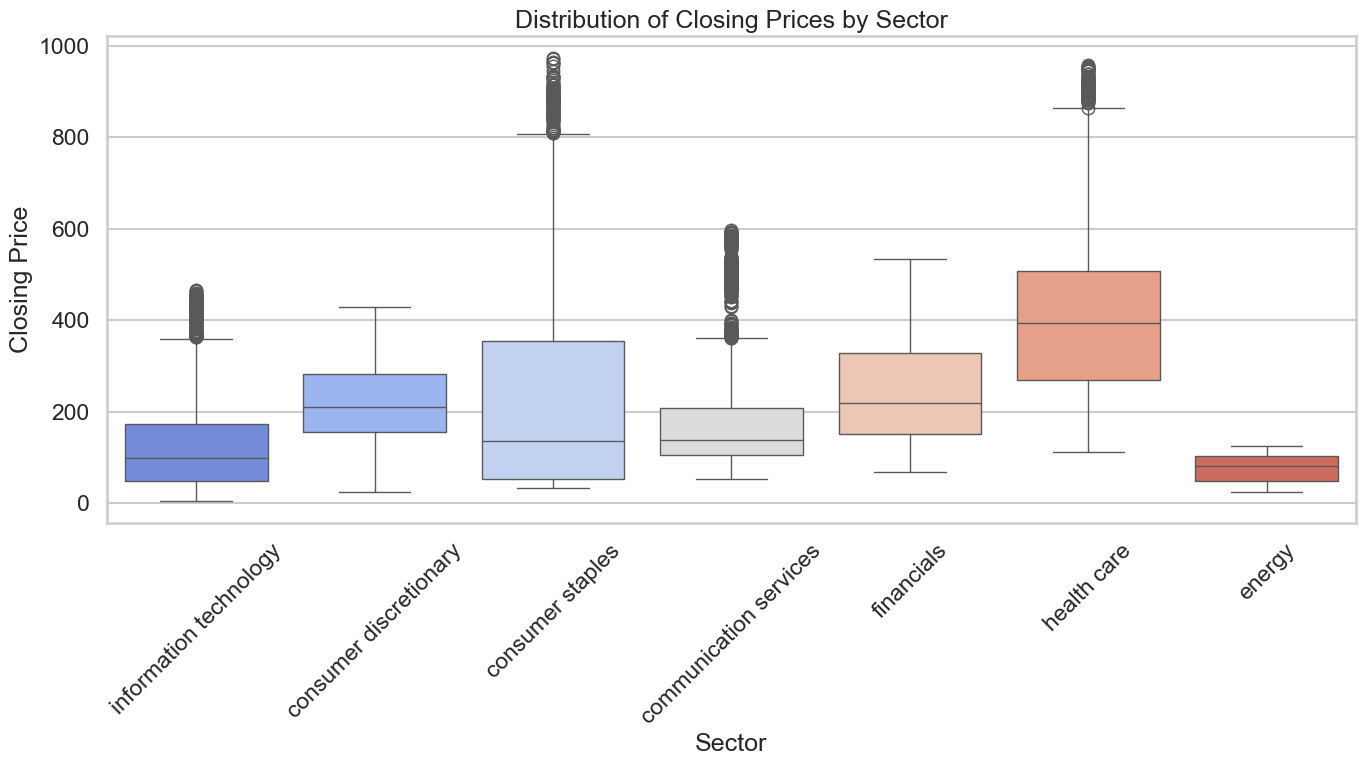

In [32]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=master_2020, x="sector", y="close", palette="coolwarm")
plt.title("Distribution of Closing Prices by Sector")
plt.xlabel("Sector")
plt.ylabel("Closing Price")
plt.xticks(rotation=45)
plt.tight_layout()

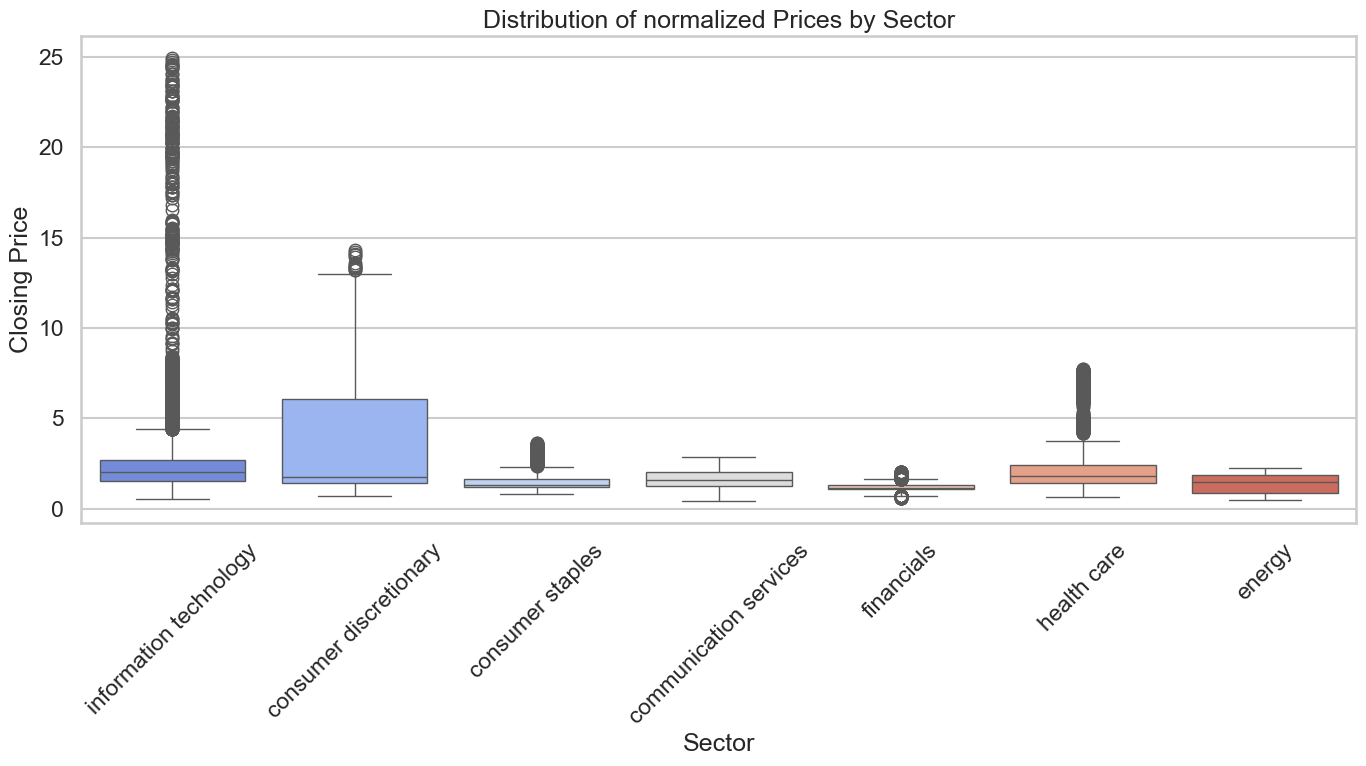

In [33]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=master_2020, x="sector", y="norm_price_2020", palette="coolwarm")
plt.title("Distribution of normalized Prices by Sector")
plt.xlabel("Sector")
plt.ylabel("Closing Price")
plt.xticks(rotation=45)
plt.tight_layout()

### Violin

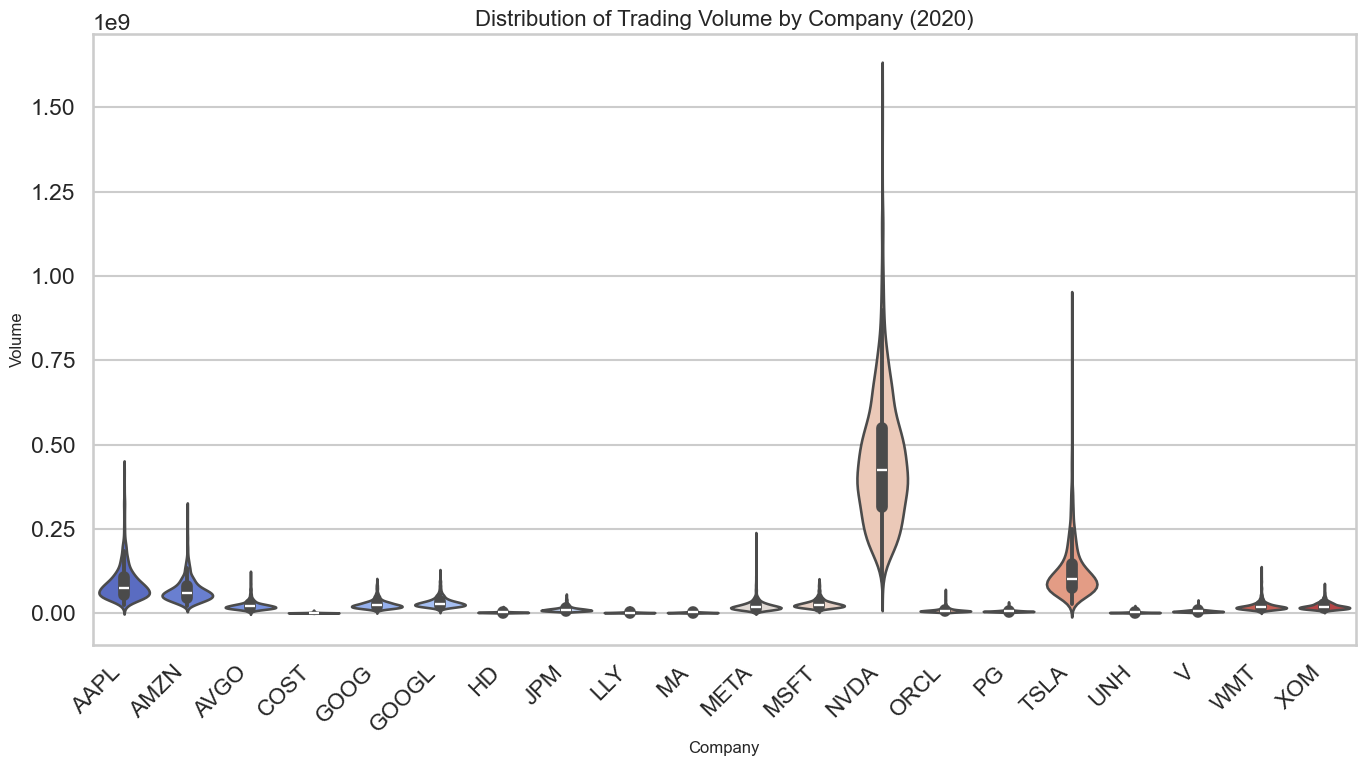

In [34]:
# Set the style and context for the plot
sns.set(style="whitegrid", context="talk")

# Create the boxplot
plt.figure(figsize=(14, 8))  # Adjust the figure size for better readability
sns.violinplot(data=master_2020, x="company", y="volume", palette="coolwarm")

# Improve labels and titles
plt.title('Distribution of Trading Volume by Company (2020)', fontsize=16)
plt.xlabel('Company', fontsize=12)
plt.ylabel('Volume', fontsize=12)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha="right")

# Adjust layout for better fit
plt.tight_layout()

# Show plot
plt.show()

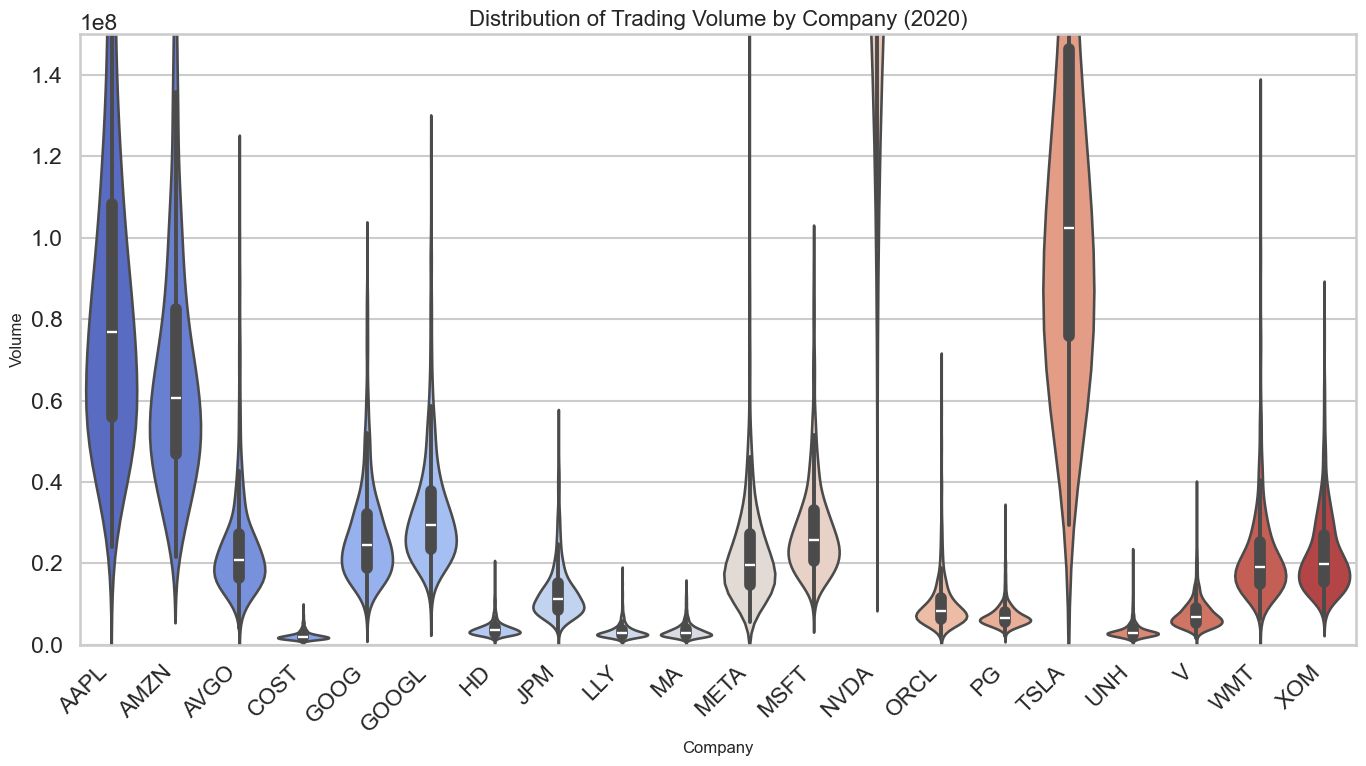

In [35]:
plt.figure(figsize=(14, 8))
sns.violinplot(data=master_2020, x="company", y="volume", palette="coolwarm")

plt.ylim(0, 150000000)  # Set your own limits here

plt.title('Distribution of Trading Volume by Company (2020)', fontsize=16)
plt.xlabel('Company', fontsize=12)
plt.ylabel('Volume', fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Scatterplots

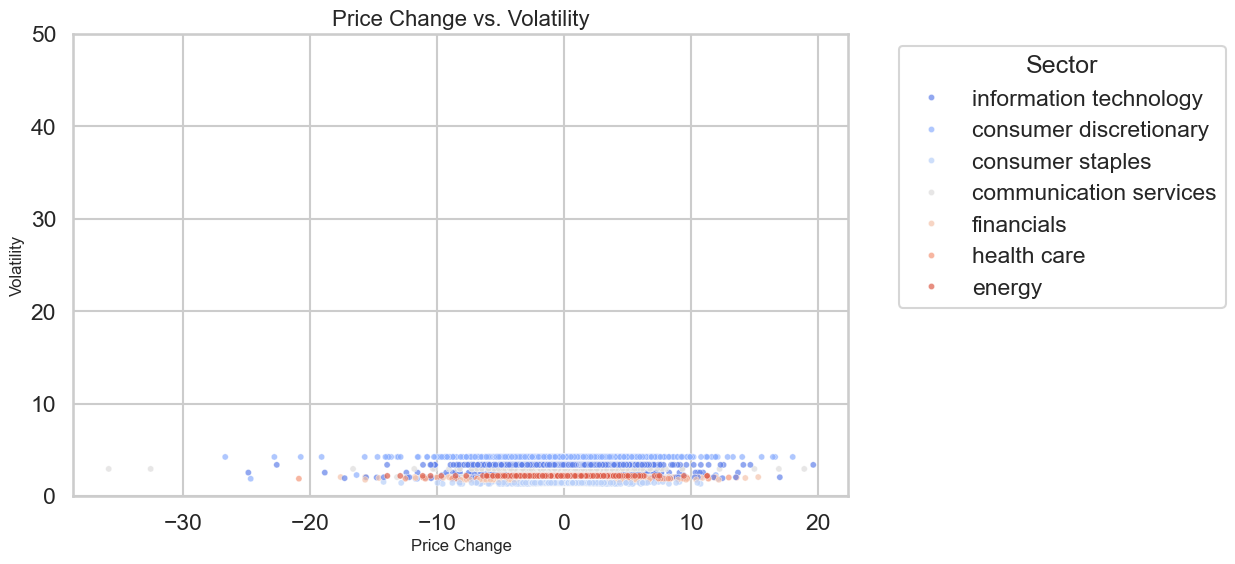

In [36]:
# Set a style for the plot
sns.set_style("whitegrid")

# Create the scatter plot
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    data=master_2020, 
    y="volatility", 
    x="price_change", 
    palette="coolwarm", 
    hue="sector", 
    s=20,  # Marker size
    alpha=0.7  # Transparency
    
)

# Add a title and axis labels
scatter_plot.set_title("Price Change vs. Volatility", fontsize=16)
scatter_plot.set_ylabel("Volatility", fontsize=12)
scatter_plot.set_xlabel("Price Change", fontsize=12)

plt.ylim(0, 50)  # Set your own limits here


# Adjust the legend
scatter_plot.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')

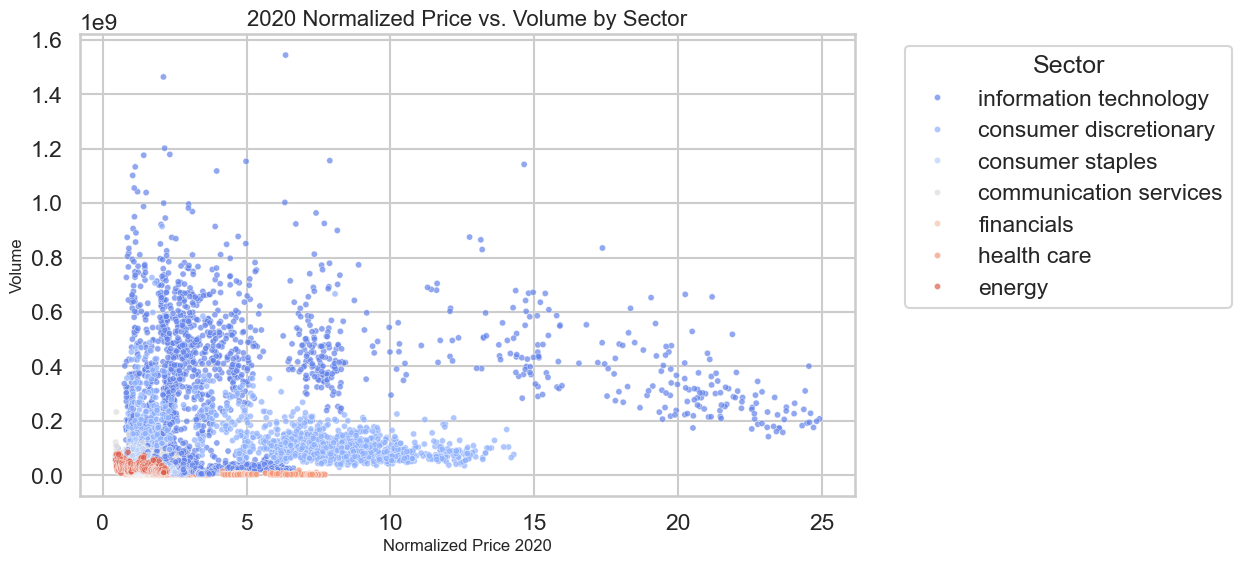

In [37]:
# Set a style for the plot
sns.set_style("whitegrid")

# Create the scatter plot
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    data=master_2020, 
    x="norm_price_2020", 
    y="volume", 
    palette="coolwarm", 
    hue="sector", 
    s=20,  # Marker size
    alpha=0.7  # Transparency
)

# Add a title and axis labels
scatter_plot.set_title("2020 Normalized Price vs. Volume by Sector", fontsize=16)
scatter_plot.set_xlabel("Normalized Price 2020", fontsize=12)
scatter_plot.set_ylabel("Volume", fontsize=12)

# Adjust the legend
scatter_plot.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')


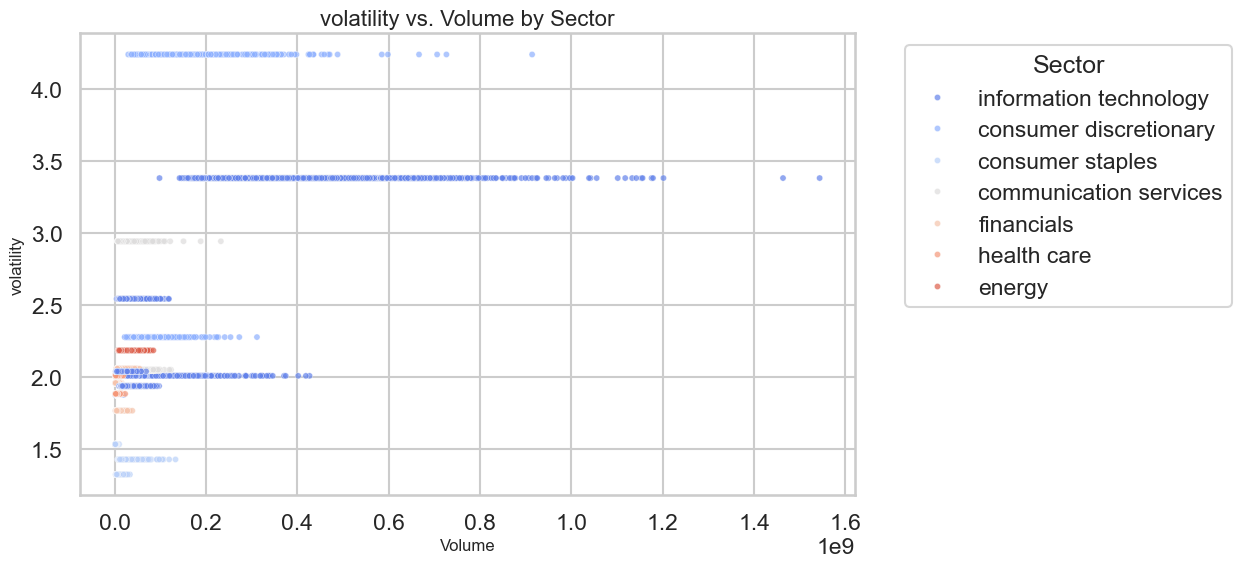

In [38]:
# Set a style for the plot
sns.set_style("whitegrid")

# Create the scatter plot
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    data=master_2020, 
    y="volatility", 
    x="volume", 
    palette="coolwarm", 
    hue="sector", 
    s=20,  # Marker size
    alpha=0.7  # Transparency
)

# Add a title and axis labels
scatter_plot.set_title("volatility vs. Volume by Sector", fontsize=16)
scatter_plot.set_xlabel("Volume", fontsize=12)
scatter_plot.set_ylabel("volatility", fontsize=12)

# Adjust the legend
scatter_plot.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')

In [39]:

# Create a scatter plot with Plotly
fig = px.scatter(
    master_2020,
    x="volume",
    y="norm_price_2020",
    color="sector",
    color_continuous_scale=px.colors.sequential.Viridis,
    size_max=40,  # Adjust this value to make points smaller
    opacity=0.7,
    labels={"sector": "Sector", "volume": "Volume", "norm_price_2020": "Normalized Price (2020)"}
)

# Update layout to mimic the aesthetics of the Matplotlib plot and adjust height
fig.update_layout(
    title="Normalized Prices vs Trading Volume by Sector",
    title_font_size=18,
    xaxis_title="Volume",
    yaxis_title="Normalized Price (2020)",
    legend_title_text="Sector",
    height=1000,  # Adjust this value to make the plot higher
    legend=dict(
        x=1.05,
        y=1,
        yanchor='top',
        xanchor='left',
        title_font_size=14
    )
)

### Barplots

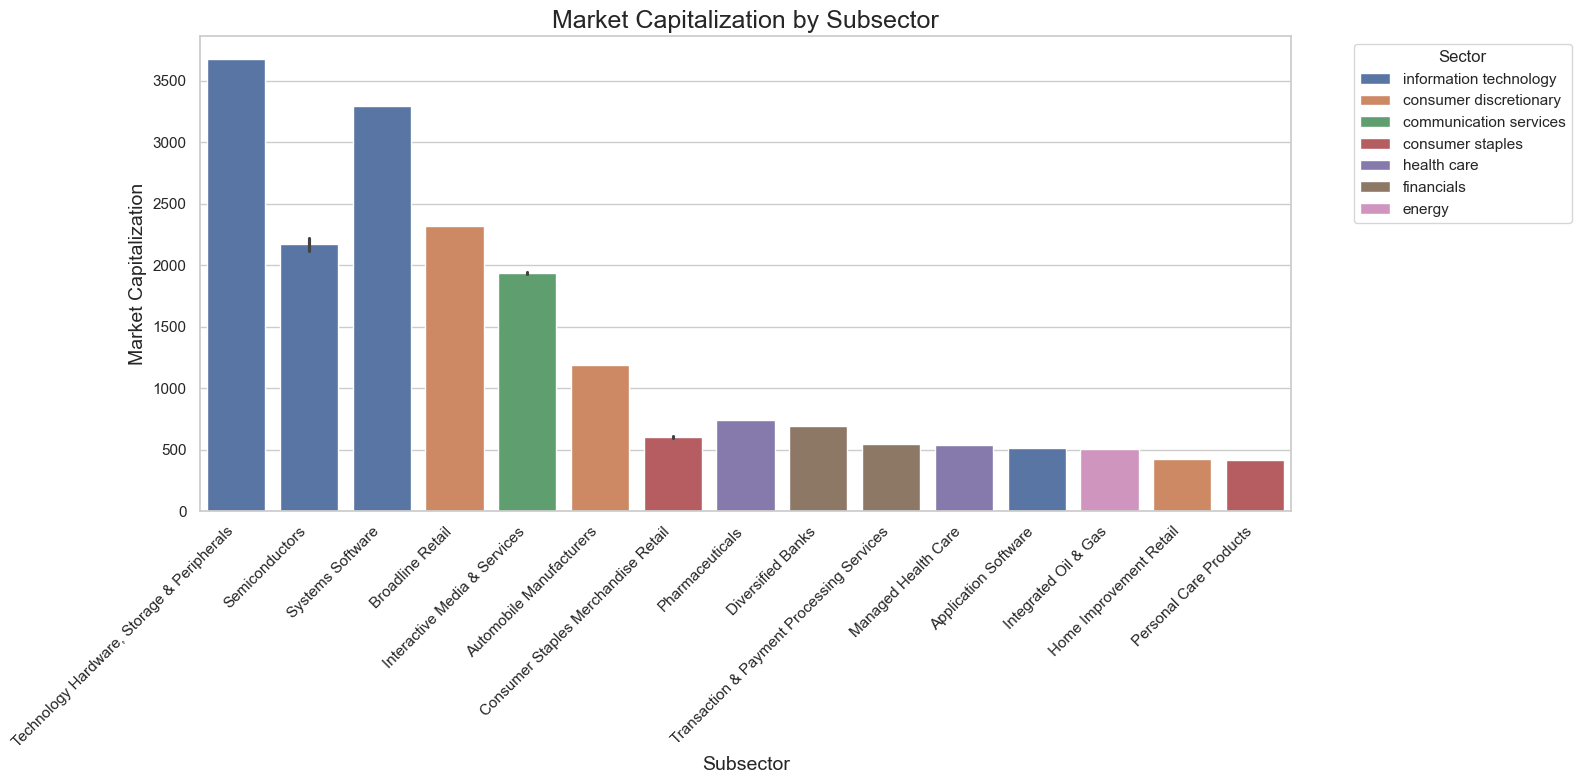

In [40]:
# Sort the data by market cap
sorted_data = master_2020.sort_values(by="marketcap", ascending=False)

# Set the style
sns.set(style="whitegrid")

# Create the barplot
plt.figure(figsize=(16, 8))
sns.barplot(x="subsector", y="marketcap", data=sorted_data, hue="sector")

# Enhance plot appearance
plt.title("Market Capitalization by Subsector", fontsize=18)
plt.xlabel("Subsector", fontsize=14)
plt.ylabel("Market Capitalization", fontsize=14)
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.legend(title="Sector", bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend to avoid overlap
plt.tight_layout()

### heatmap

In [41]:
num = master_2020.copy()
num = master_2020.select_dtypes("number")

Text(0.5, 1.0, 'Dealing with Multicollinearity')

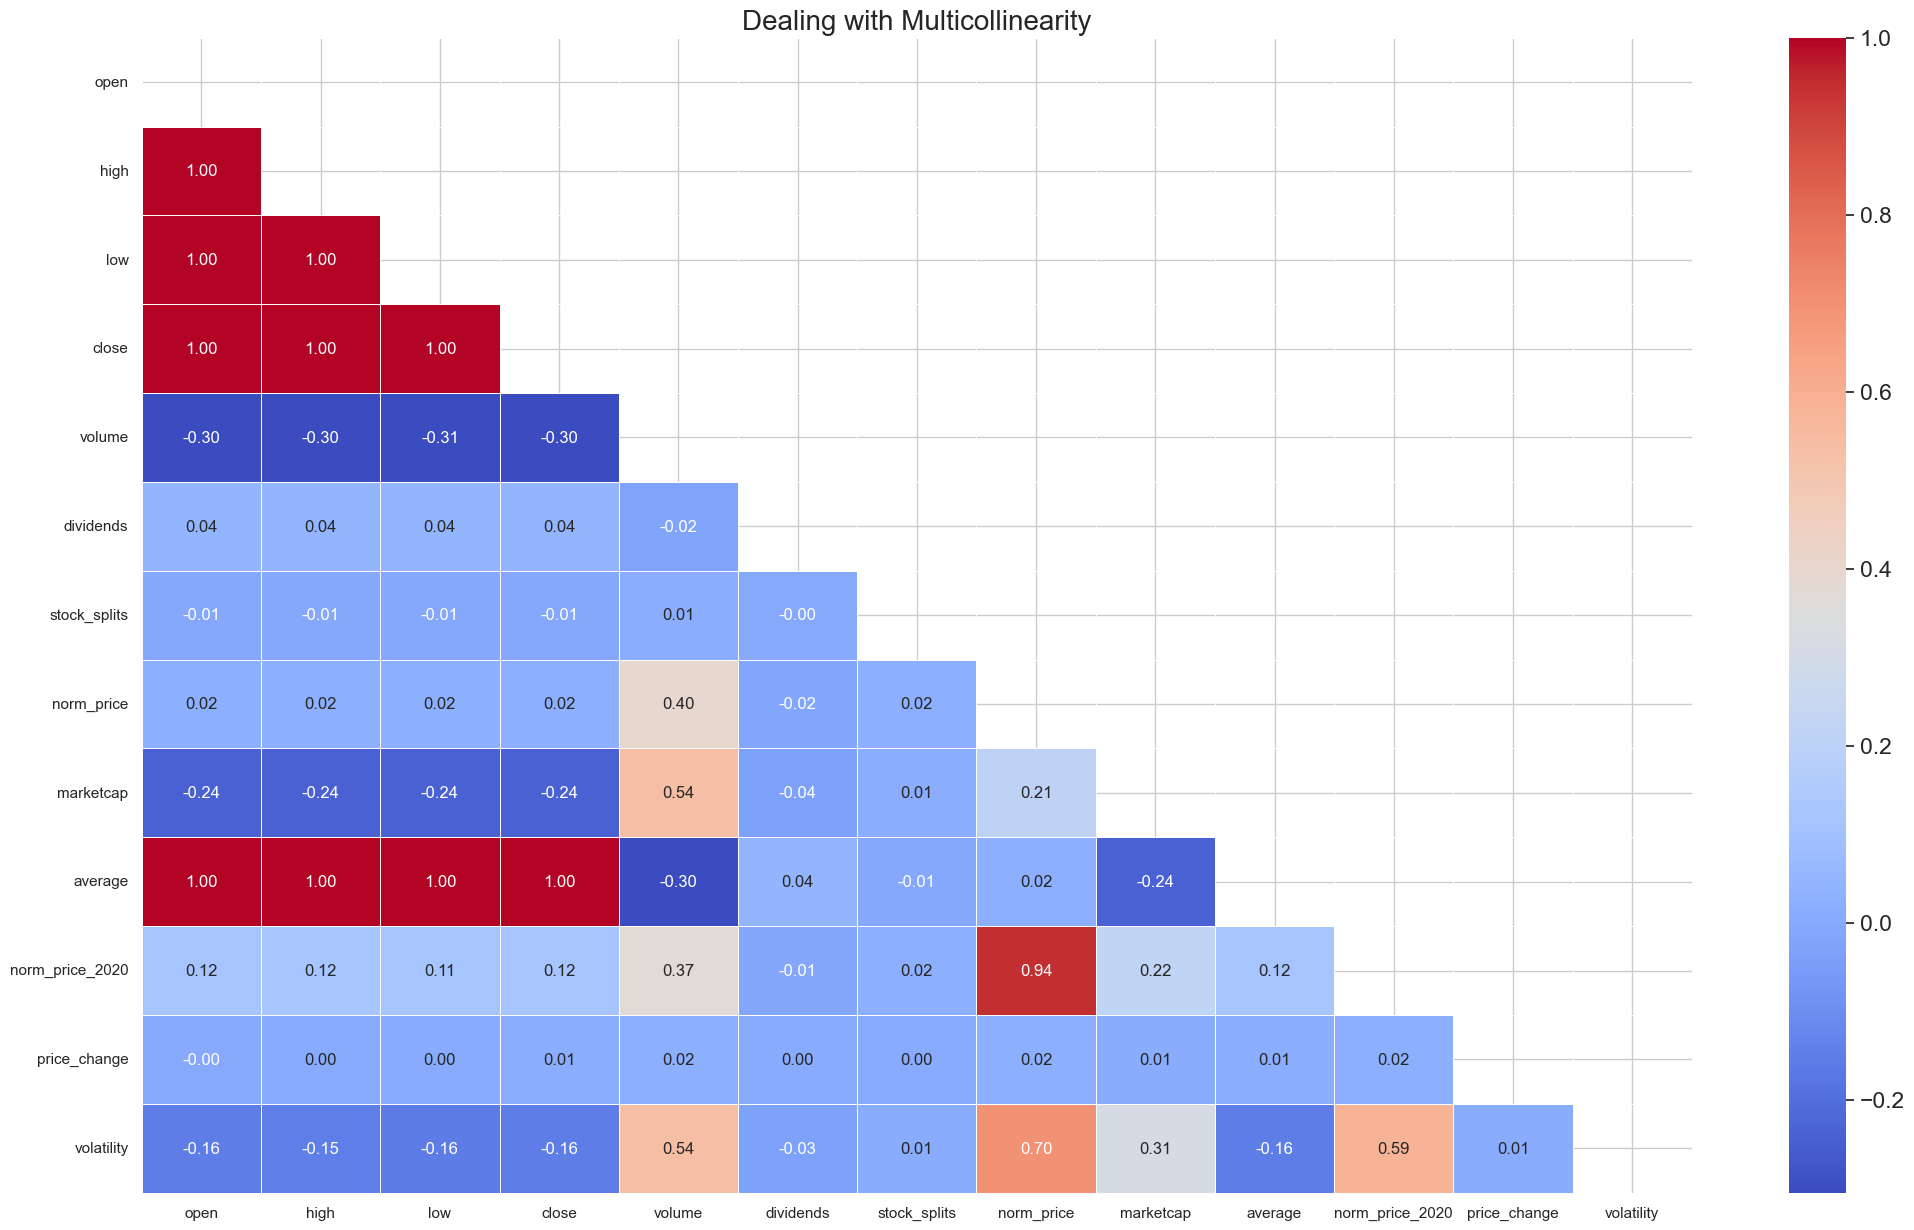

In [42]:
# Correlation Matrix-Heatmap Plot
correlation_matrix = num.corr()

mask = np.zeros_like(correlation_matrix)
mask[np.triu_indices_from(mask)] = True # optional, to hide repeat half of the matrix
f, ax = plt.subplots(figsize=(25, 15))
sns.set(font_scale=1.5) # increase font size
ax = sns.heatmap(correlation_matrix, mask=mask, annot=True, annot_kws={"size": 12}, linewidths=.5, cmap="coolwarm", fmt=".2f", ax=ax) # round to 2 decimal places
ax.set_title("Correlation Matrix", fontsize=20) # add title

### others

### Ukr

In [43]:
# inspect dip in 2020 (war in Ukraine)
ukr_2020 = df_2010.copy()
ukr_2020 = ukr_2020.loc["2020":"2020"]

In [44]:
ukr_2020

,date,open,high,low,close,volume,dividends,stock_splits,company,norm_price_2010


In [45]:
# standardize price for start of 2020
for i in ukr_2020["company"].unique():
    start_value = ukr_2020[ukr_2020["company"] == i].iloc[0]["close"]
    ukr_2020.loc[ukr_2020["company"] == i, "ukr_price"] = ukr_2020.loc[ukr_2020["company"] == i, "close"] / start_value

In [46]:
# getting winner of war

top_30_ukr = ukr_2020.tail(500)
top_30_ukr = top_30_ukr.sort_values(by="ukr_price", ascending=False).head(30)
top_30_ukr = list(top_30_ukr["company"])

px.line(ukr_2020[ukr_2020["company"].isin(top_30_ukr[:5])], x="date", y="ukr_price", color="company", width=800, height=500)

KeyError: 'ukr_price'

In [ ]:
# plot with 5 winner, 5 loser, average

In [ ]:
# prepare datasets for tableau

In [ ]:
# min, max, average while 2020

sns.lineplot(data=ukr_2020, x="date", y="ukr_price", ci=None, estimator=np.min)
sns.lineplot(data=ukr_2020, x="date", y="ukr_price", ci=None, estimator=np.mean)
sns.lineplot(data=ukr_2020, x="date", y="ukr_price", ci=None, estimator=np.max)


plt.grid(True) 
plt.title("Mean S&P 500") 
plt.xlabel("Date") 
plt.ylabel("ukr_price")
plt.legend(title='Metrics', loc='best')


In [ ]:
# plotting top 5 relative prices

top_30 = df_2010.tail(500)
top_30 = top_30.sort_values(by="norm_price", ascending=False).head(30)
top_30 = list(top_30["company"])

# plotting top 5 relative prices
sns.lineplot(data=df_2010[df_2010["company"].isin(top_30[:5])], x="date", y="norm_price", hue="company")
plt.grid(True)

In [ ]:
# plotting top 5 relative prices
px.line(df_2010[df_2010["company"].isin(top_30[:5])], x="date", y="norm_price", color="company", width=800, height=500)